In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import time
from dataloader import preprocess_data, construct_datasets

In [ ]:
train_data = preprocess_data(pd.read_csv(r'..\dat\walks\random_walk_600min.csv'))
val_data = preprocess_data(pd.read_csv(r'..\dat\walks\random_walk_300min.csv'))
test_data = preprocess_data(pd.read_csv(r'..\dat\walks\random_walk_180min.csv'))
train_data.columns

Index(['finestep', 'time', 'c_0', 'c_1', 'c_2', 'c_3', 'c_4', 'c_mean',
       'step_diff', 'step_60rsum_exp', 'step_120rsum_exp', 'step_300rsum_exp',
       'step_600rsum_exp', 'c_mean_unnorm', 'c_mean_lag10', 'c_mean_10rmean',
       'c_mean_lag60', 'c_mean_60rmean', 'c_mean_lag120', 'c_mean_120rmean',
       'c_mean_lag300', 'c_mean_300rmean', 'c_mean_lag600', 'c_mean_600rmean'],
      dtype='object')

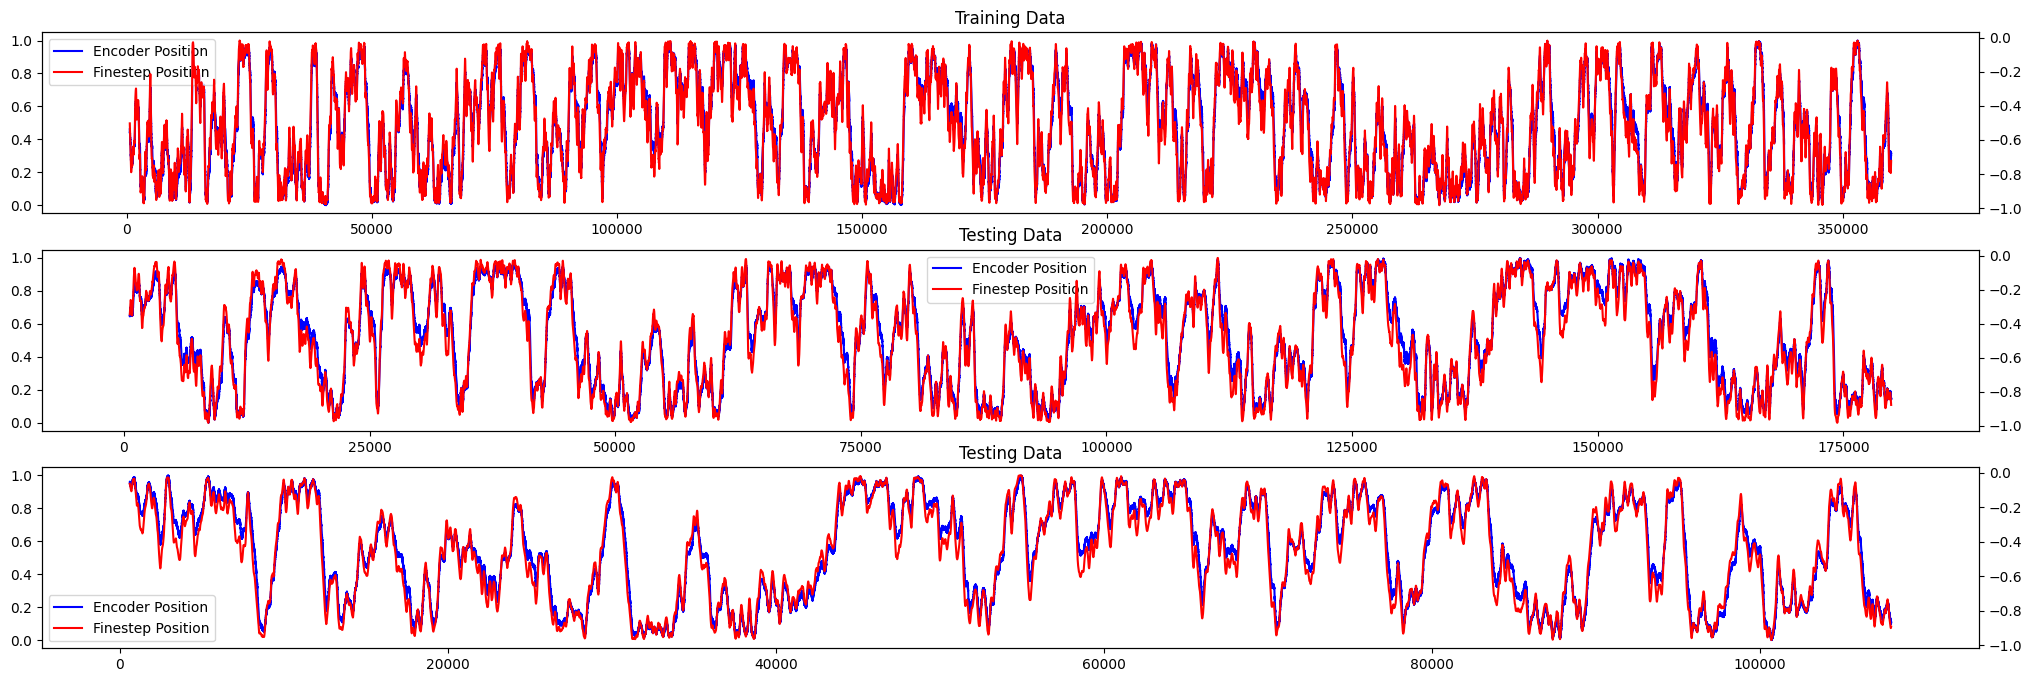

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(25, 8))

ax[0].title.set_text('Training Data')
ax[0].plot(train_data['c_mean'], label='Encoder Position', color='blue')
ax2 = ax[0].twinx()
ax2.plot(-train_data['finestep'], label='Finestep Position', color='red')

ax[1].title.set_text('Testing Data')
ax[1].plot(val_data['c_mean'], label='Encoder Position', color='blue')
ax12 = ax[1].twinx()
ax12.plot(-val_data['finestep'], label='Finestep Position', color='red')

ax[2].title.set_text('Testing Data')
ax[2].plot(test_data['c_mean'], label='Encoder Position', color='blue')
ax22 = ax[2].twinx()
ax22.plot(-test_data['finestep'], label='Finestep Position', color='red')

# merge legends
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax[1].get_legend_handles_labels()
lines4, labels4 = ax12.get_legend_handles_labels()
lines5, labels5 = ax[2].get_legend_handles_labels()
lines6, labels6 = ax22.get_legend_handles_labels()
ax[0].legend(lines + lines2, labels + labels2, loc=0)
ax[1].legend(lines3 + lines4, labels3 + labels4, loc=0)
ax[2].legend(lines5 + lines6, labels5 + labels6, loc=0)


#ax[0].set_xlim(100000, 170000)
plt.show()


In [44]:
import numpy as np
import warnings
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, KFold

columns_input = ['finestep', 'step_diff', 'step_60rsum_exp', 'step_120rsum_exp', 'step_300rsum_exp',
                 'step_600rsum_exp', 'c_mean_lag10', 'c_mean_10rmean', 'c_mean_lag60', 'c_mean_60rmean',
                 'c_mean_lag120', 'c_mean_120rmean', 'c_mean_lag300', 'c_mean_300rmean', 'c_mean_lag600',
                 'c_mean_600rmean']

# Assuming construct_datasets function is defined elsewhere
X_train, y_train, X_val, y_val, X_test, y_test = construct_datasets(train_data, val_data, test_data, columns_input)

# Adjusting the alpha range for finer granularity
alpha_range = np.logspace(-4, -0.5, 30)

# Using RandomizedSearchCV instead of GridSearchCV for efficiency
random_search = RandomizedSearchCV(Lasso(), param_distributions={"alpha": alpha_range}, n_iter=100, cv=KFold(n_splits=10), verbose=1)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    random_search.fit(X_train, y_train)

best_alpha = random_search.best_params_['alpha']
print(f"Best Alpha: {best_alpha}")

# Fit the final model with the best alpha
final_lasso = Lasso(alpha=best_alpha)
final_lasso.fit(X_train, y_train)

# Evaluate the model
train_score = final_lasso.score(X_train, y_train)
val_score = final_lasso.score(X_val, y_val)
print(f"Training Score: {train_score}")
print(f"Validation Score: {val_score}")


Best Alpha: 0.0001
Training Score: 0.9997542055162083
Validation Score: 0.9997732648050606


c:\Users\David\miniforge3\envs\fp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.152e+00, tolerance: 2.995e+00
  model = cd_fast.enet_coordinate_descent(


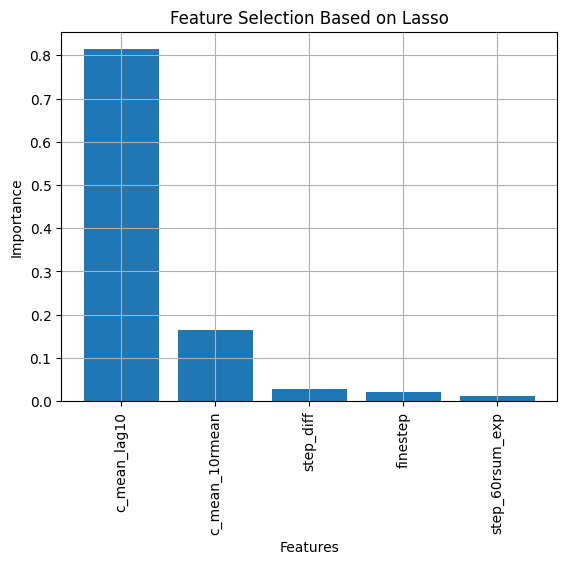

In [46]:
significant_features = np.where(np.abs(final_lasso.coef_) > 0.01)[0]
lasso_coefs_arg = np.argsort(np.abs(final_lasso.coef_[significant_features]))[::-1]
columns_input_sorted = np.array(columns_input)[significant_features][lasso_coefs_arg]
lasso_coefs = np.abs(final_lasso.coef_[significant_features][lasso_coefs_arg])

# plotting the Column Names and Importance of Columns. 
plt.bar(columns_input_sorted, lasso_coefs)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
#plt.ylim(0, 0.01)
plt.show()

In [52]:
# Subsetting the features which has more than 0.001 importance.
columns_input=np.array(columns_input)[significant_features]
#columns_input = np.append(columns_input, 'c_mean')
print("Selected Feature Columns: {}".format(columns_input))

Selected Feature Columns: ['finestep' 'step_diff' 'step_60rsum_exp' 'c_mean_lag10' 'c_mean_10rmean']


In [ ]:
import numpy as np
import warnings
from sklearn.linear_model import Lasso

columns_input = ['finestep', 'step_diff', 'step_60rsum_exp', 'step_120rsum_exp', 'step_300rsum_exp',
                 'step_600rsum_exp', 'c_mean_lag10', 'c_mean_10rmean', 'c_mean_lag60', 'c_mean_60rmean',
                 'c_mean_lag120', 'c_mean_120rmean', 'c_mean_lag300', 'c_mean_300rmean', 'c_mean_lag600',
                 'c_mean_600rmean']

# Assuming construct_datasets function is defined elsewhere
X_train, y_train, X_val, y_val, X_test, y_test = construct_datasets(train_data, val_data, test_data, columns_input)
# Fit the final model with the best alpha
final_lasso = Lasso(alpha=best_alpha)
final_lasso.fit(X_train, y_train)

# Evaluate the model
train_score = final_lasso.score(X_train, y_train)
val_score = final_lasso.score(X_val, y_val)
print(f"Training Score: {train_score}")
print(f"Validation Score: {val_score}")

significant_features = np.where(np.abs(final_lasso.coef_) > 0.01)[0]
lasso_coefs_arg = np.argsort(np.abs(final_lasso.coef_[significant_features]))[::-1]
columns_input_sorted = np.array(columns_input)[significant_features][lasso_coefs_arg]
lasso_coefs = np.abs(final_lasso.coef_[significant_features][lasso_coefs_arg])

# plotting the Column Names and Importance of Columns. 
plt.bar(columns_input_sorted, lasso_coefs)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
#plt.ylim(0, 0.01)
plt.show()